In [1]:
# our nice list of imports is in here
#i hate this, but the notebook won't recognize our custom modules w/o it
import sys
sys.path.append("..")
import lib
from lib import utils

import numpy as np
import pandas as pd
import os
import urllib
import random
from shutil import copyfile, move
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential        # keras is only compatible with python 3.6 or lower
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


from skimage import io, data
from skimage.util import img_as_ubyte
from skimage.transform import rescale

import sklearn
from sklearn.preprocessing import LabelEncoder

from mtcnn.mtcnn import MTCNN

from IPython.display import clear_output

import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

Using TensorFlow backend.


# Face Mask Detection


### Brief Overview

Simply put, our goal is to create a neural network that will (1) identify face masks or lack thereof on a human face, and (2) determine whether that facemask is correctly worn.


Luckily for us, Kaggle had a contest earlier this year related to (1) -- so a dataset was readily available, and it has proven to be quite effective at training a mask/no-mask neural net with our testing images. (Kaggle)


However, the dataset is extremely lacking when it comes to incorrect mask usage.  We did locate an additional dataset that consists only of faces with correctly worn masks and incorrectly worn masks. (CMFD/IMFD)

### Data

1. Training Data - We have training data from both datasets.  The images in each set have been pre-processed with relevant data written to CSV files to ease the process load.
  + Kaggle Dataset -- 
2. Testing Data - Our testing data consists of 


### Models

To that end, we need a few different models:
1. One to predict whether there's a mask on a face or no mask
  + For this, we will use the Kaggle Dataset, and focus on the two largest features available in it: whether there is a face mask or not.
  + Potentially, we could add the data from the CMFD/IMFD dataset as representations of masks for the training set, since we'll be determining whether they're correct or incorrectly worn in the next stage.  The only concern there is a dataset that's very, very heavy on masks vs. no masks
2. One to predict whether, given a mask is on a face, it is worn correctly
  + For this, we will use the CMFD/IMFD dataset.  There are only two features to this dataset: correctly worn and incorrectly worn face masks.




In [2]:
# define directory paths for easier navigation
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = NOTEBOOK_DIR[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
IMG_DATA_DIR = os.path.join(DATA_DIR, 'img_data')
KAGGLE_DIR = os.path.join(IMAGES_DIR, 'kaggle')
HC_DATA_DIR = os.path.join(DATA_DIR, 'haar_cascades')

# MNM_TRIAL_DIR = os.path.join(IMAGES_DIR, 'mnm_trial')
# MNM_TRAINING = os.path.join(MNM_TRIAL_DIR, 'training')
# MNM_TESTING = os.path.join(MNM_TRIAL_DIR, 'testing')

PRAJNA_SRC_DIR = os.path.join(DATA_DIR, 'prajna-dataset')
PMASK_SRC = os.path.join(PRAJNA_SRC_DIR, 'mask')
PNOMASK_SRC = os.path.join(PRAJNA_SRC_DIR, 'nomask')

PTRAINING_DIR = os.path.join(PRAJNA_SRC_DIR, 'dest/train')
PTESTING_DIR = os.path.join(PRAJNA_SRC_DIR, 'dest/test')
PVAL_DIR = os.path.join(PRAJNA_SRC_DIR, 'dest/val')

PTRAINING_MASK = os.path.join(PRAJNA_SRC_DIR, 'dest/train/mask')
PTESTING_MASK = os.path.join(PRAJNA_SRC_DIR, 'dest/test/mask')
PVAL_MASK = os.path.join(PRAJNA_SRC_DIR, 'dest/val/mask')

PTRAINING_NOMASK = os.path.join(PRAJNA_SRC_DIR, 'dest/train/nomask')
PTESTING_NOMASK = os.path.join(PRAJNA_SRC_DIR, 'dest/test/nomask')
PVAL_NOMASK = os.path.join(PRAJNA_SRC_DIR, 'dest/val/nomask')


EXTENDED_SRC_DIR = os.path.join(DATA_DIR, 'extended-dataset')
EMASK_SRC = os.path.join(EXTENDED_SRC_DIR, 'mask')
ENOMASK_SRC = os.path.join(EXTENDED_SRC_DIR, 'nomask')

ETRAINING_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/train')
ETESTING_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/test')
EVAL_DIR = os.path.join(EXTENDED_SRC_DIR, 'dest/val')

ETRAINING_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/train/mask')
ETESTING_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/test/mask')
EVAL_MASK = os.path.join(EXTENDED_SRC_DIR, 'dest/val/mask')

ETRAINING_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/train/nomask')
ETESTING_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/test/nomask')
EVAL_NOMASK = os.path.join(EXTENDED_SRC_DIR, 'dest/val/nomask')


SRC_DIR = os.path.join(DATA_DIR, 'face_mask_data')
MASK_SRC = os.path.join(SRC_DIR, 'mask')
NOMASK_SRC = os.path.join(SRC_DIR, 'nomask')

TRAINING_DIR = os.path.join(SRC_DIR, 'dest/train')
TESTING_DIR = os.path.join(SRC_DIR, 'dest/test')
VAL_DIR = os.path.join(SRC_DIR, 'dest/val')

TRAINING_MASK = os.path.join(SRC_DIR, 'dest/train/mask')
TESTING_MASK = os.path.join(SRC_DIR, 'dest/test/mask')
VAL_MASK = os.path.join(SRC_DIR, 'dest/val/mask')

TRAINING_NOMASK = os.path.join(SRC_DIR, 'dest/train/nomask')
TESTING_NOMASK = os.path.join(SRC_DIR, 'dest/test/nomask')
VAL_NOMASK = os.path.join(SRC_DIR, 'dest/val/nomask')




# MASK_SRC_DIR=os.path.join(MNM_TRIAL_DIR, 'mask')
# TRAINING_MASK=os.path.join(MNM_TRAINING, 'mask')
# TESTING_MASK=os.path.join(MNM_TESTING, 'mask')

# NOMASK_SRC_DIR=os.path.join(MNM_TRIAL_DIR, 'nomask')
# TRAINING_NOMASK=os.path.join(MNM_TRAINING, 'nomask')
# TESTING_NOMASK=os.path.join(MNM_TESTING, 'nomask')

KAGGLE_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images"
# CMFD_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images/CMFD/images"
# IMFD_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images/IMFD/images"

# Mask vs. No Mask (MNM)

## Model Preparations

+ We keep pre-compiled versions of our different models on hand (again, to reduce process/load times)
+ Unless the training data changes, we default to using those existing models

1. First model used ONLY Prajna Dataset (97% acc)
2. Second model is training now, with additional 'no mask' images from Kaggle
3. Third will have additional 'mask' images from kaggle

**DON'T FORGET TO REVERT IMAGES TO BEST MODEL VERSION**

In [3]:
# def data_summary(main_path):
    
#     yes_path = main_path+'/mask'
#     no_path = main_path+'/nomask'
        
#     # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
#     m_pos = len(os.listdir(yes_path))
#     # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
#     m_neg = len(os.listdir(no_path))
#     # number of all examples
#     m = (m_pos+m_neg)
    
#     pos_prec = (m_pos* 100.0)/ m
#     neg_prec = (m_neg* 100.0)/ m
    
#     print(f"Number of examples: {m}")
#     print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
#     print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
# augmented_data_path = os.path.join(EXTENDED_SRC_DIR, 'dest')
# data_summary(augmented_data_path)

In [4]:
def split_data(src, train, test, split_size):
    dataset = []
    
    for unitData in os.listdir(src):
        data = os.path.join(src, unitData)
        if(os.path.getsize(data) > 0 and os.path.isfile(data)):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * split_size)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = os.path.join(src, unitData)
        final_train_set = os.path.join(train, unitData)
        
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = os.path.join(src, unitData)
        final_test_set = os.path.join(test, unitData)
        copyfile(temp_test_set, final_test_set)

        
split_size = 0.8
split_data(MASK_SRC, TRAINING_MASK, TESTING_MASK, split_size)
split_data(NOMASK_SRC, TRAINING_NOMASK, TESTING_NOMASK, split_size)


## Keras Sequential Model

#### Building the Model
In this proposed method, the Face Mask detection model is built using the Sequential API of the keras library. This allows us to create the new layers for our model step by step. The various layers used for our CNN model is described below.

1. The first layer is Conv2D with **100 kernels** of size $3\times3$. 
  + The activation function is ‘ReLu’.  
  + The input size is set to $150\times 150 \times 3$ for all the images to be trained and tested

2. MaxPooling2D is used for the second layer with pool size of $2 \times 2$.

3. The next layer is another Conv2D layer 
  + Has its own 100 kernels of the same size: $3\times3$ 
  + Activation function is ‘ReLu’. 
  + The layer is followed by another MaxPooling2D layer with pool size $2 \times 2$.

4. Then the Flatten() layer to flatten *all* the layers into a single dimension.

5. **NEW:** After the Flatten layer, we added dropout (0.5) layer to prevent the model from overfitting -- which was killing us in early trials.

6. Then we used the Dense layer 
  + 50 'units' 
  + Activation function: ‘ReLu’.

7. The last layer of our model will be another Dense Layer, with only two units and activation function ‘Softmax’. The softmax function outputs a vector representing the probability distributions of each of the input units. Here, two input units are used. The softmax function will output a vector with two probability distribution values: is there a mask on this face or not?

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

kernel_size = (3, 3)
image_shape = (150, 150, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, kernel_size, activation='tanh', input_shape=image_shape, strides=2),
    tf.keras.layers.MaxPooling2D(2,2),
    
#     tf.keras.layers.Conv2D(100, (3,3), activation='tanh'),
#     tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, kernel_size, activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),   # previously we were way overfitting, so we added dropout
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

opt = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

## Generating Training/Testing/Validation Data

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(ETRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(ETESTING_DIR, 
                                                              batch_size=10, 
                                                              target_size=(150, 150))

# (1) train the all data extended model
# (2) re-train prajna, prajna-kaggle-mask to save new checkpoints (and load them :D)
# (3) also try and do one model where only new masks are added to the set

# model_path = '../models/mnm/prajna'
# checkpoint_path = '../models/mnm/prajna.checkpoint' 

model_path = '../models/mnm/new_dataset_tanh'
checkpoint_path = '../models/mnm/new_dataset_tanh.checkpoint'

# model_path = '../models/mnm/prajna-kaggle-nomask-extend'
# checkpoint_path = '../models/mnm/prajna-kaggle-nomask-extend-{epoch:03d}.model'
# model_path = '../models/mnm/prajna-kaggle-mask-extend'
# checkpoint_path = '../models/mnm/prajna-kaggle-mask-extend-{epoch:03d}.model'
# model_path = '../models/mnm/prajna-kaggle-all-extend'
# checkpoint_path = '../models/mnm/prajna-kaggle-all-extend-{epoch:03d}.model'


# NOTE: here's something cool - we can use checkpoints
#       to save/load the weights from previous model training
# if os.path.exists(checkpoint_path):
#     model.load_weights(os.path.join(checkpoint_path, 'variables/variables'))
    
# alternatively, we can load the whole model from the checkpoint state
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True,
    mode = 'auto'
)

logger = CSVLogger(os.path.join(model_path, 'logs/training.csv'))

Found 1680 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [7]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint, logger])

Epoch 1/30
167/168 [============================>.] - ETA: 0s - loss: 0.2283 - acc: 0.9156
Epoch 00001: val_loss improved from inf to 0.13332, saving model to ../models/mnm/new_dataset_tanh.checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/mnm/new_dataset_tanh.checkpoint/assets
168/168 [==============================] - 115s 687ms/step - loss: 0.2293 - acc: 0.9149 - val_loss: 0.1333 - val_acc: 0.9525
Epoch 2/30
167/168 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9084
Epoch 00002: val_loss improved from 0.13332 to 0.13156, saving model to ../models/mnm/new_dataset_tanh.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/new_dataset_tanh.checkpoint/assets
168/168 [==============================] - 146s 870ms/step - loss: 0.2295 - acc: 0.9083 - val_loss: 0.1316 - val_acc: 0.9549
Epoch 3/30
167/168 [============================>.] - ETA: 0s - loss: 0.2289 - acc: 0.9138
Epoc

Epoch 26/30
167/168 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9168
Epoch 00026: val_loss did not improve from 0.09513
168/168 [==============================] - 137s 815ms/step - loss: 0.2076 - acc: 0.9167 - val_loss: 0.1038 - val_acc: 0.9691
Epoch 27/30
167/168 [============================>.] - ETA: 0s - loss: 0.1872 - acc: 0.9323
Epoch 00027: val_loss improved from 0.09513 to 0.08814, saving model to ../models/mnm/new_dataset_tanh.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/new_dataset_tanh.checkpoint/assets
168/168 [==============================] - 120s 715ms/step - loss: 0.1867 - acc: 0.9327 - val_loss: 0.0881 - val_acc: 0.9691
Epoch 28/30
167/168 [============================>.] - ETA: 0s - loss: 0.1710 - acc: 0.9395
Epoch 00028: val_loss did not improve from 0.08814
168/168 [==============================] - 153s 912ms/step - loss: 0.1703 - acc: 0.9399 - val_loss: 0.0983 - val_acc: 0.9667
Epoch 29/30
167/168 [============================

# How Did We Do?

To answer that, we have to answer a few other questions:
1. What do the training/validation results look like?
  + Can we accurately predict the data in the dataset source images?
2. How well does our model predict a completely different dataset?
  + For this, we'll use the training set from Kaggle so we can also check our accuracy
3. How well does our model predict in a different setting?
  + We'll use a live WebCam feed or video file and have our model predict in real time (or close to it -- framerate is spotty)

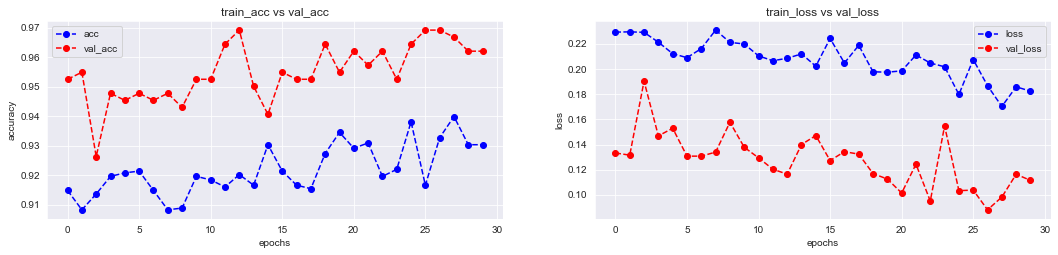

In [8]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(18,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)
# history.history
# model.history

## Predicting The Current Dataset

+ We'll start with the images in the source directory of masks
  1. First we go through the images, use facial detection to find bounding boxes and/or keypoints
  2. Then we  

In [9]:
len(os.listdir(PMASK_SRC))

694

## Predicting Another Dataset

Our model's performance in the training/validation stage was admirable.  Let's give it some images from another dataset and see how it performs with them.

In [10]:
# we'll be using the Kaggle mask detection contest training dataset
# df = pd.read_csv(os.path.join(IMG_DATA_DIR, 'kaggle_training.csv'), index_col=0)

# # the kaggle dataset actually had errors in its labeling -- on purpose
# df.rename(columns={'x1': 'x', 'x2': 'y', 'y1': 'w', 'y2': 'h'}, inplace=True)
# df.drop(['bbox'], axis=1, inplace=True)

# df = df[df['classname'].isin(['face_with_mask', 'face_with_mask_incorrect', 'face_no_mask'])]


# # df['pred'] = np.nan
                      
# test_images = list(df['name'].unique())
# df

In [11]:
# labels_dict={ 0:'No Mask', 1:'Mask' }
# color_dict={ 0: 'magenta', 1: 'cyan' }

# # name = test_images[0]
# total = len(test_images)
# counter = 1
# idx = 0
# for name in test_images:
#     # fetch the image from the remote repository
#     url = os.path.join(KAGGLE_IMAGES_DIR, "{}?raw=true".format(name))
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)


#     # locate the image within the dataframe so we can find bounding boxes
#     # NOTE: bounding boxes were pre-detected in this dataset and stored in the dataframe CSV
#     to_test = df[df['name'] == name]
#     #     print(to_test)


# #     fig, ax = plt.subplots(1)
# #     ax.imshow(image, cmap='gray')

#     preds = list()
#     # print([i for i in list(faces) if len(i) > 4])
#     for i in range(len(to_test)):
#         print("Index: {}".format(i+idx))
#         im = df.iloc[i+idx]

#         face_region = image[im['y']:im['y']+im['h'], im['x']:im['x']+im['w']]
#         if face_region.size > 0:
#             resized = cv2.resize(face_region, (450, 450))
#             normalized = resized/255.0
#             reshaped = np.reshape(normalized, (-1, 150, 150, 3))
#             reshaped = np.vstack([reshaped])
#             pred = model.predict(reshaped)
#             preds.append(pred)

#             label = np.argmax(pred, axis=1)[0]
#             df.loc[i+idx, 'pred'] = int(label)
# #             print(df[df['name'] == name])
#     idx += len(to_test)

#     print("\nAnalyzing {}/{}".format(counter, total))
#     print(df[df['name'] == name])            
#     counter += 1

#         box = (im['x'], im['y'], im['w'], im['h'])
#         rect = patches.Rectangle(
#             (box[0], box[1]), 
#             box[2]-box[0], 
#             box[3]-box[1],
#             linewidth=2,
#             edgecolor=color_dict[label],
#             facecolor='none'
#         )
#         ax.add_patch(rect)
#         ax.label = "Detecting Face Masks"
        

In [12]:
# df[0:50]

## Using Our Model With Video Feed

+ We have two available facial detection algorithms: 
  1. Haar Cascade - faster detection, but only tuned for full, frontal views of faces.
  2. MTCNN - slower detection, but returns extra features and can detect faces from a variety of angles -- not only the front.


In [17]:
# use haar cascade to detect faces (frontal)
# HC_FRONTAL_FACE = os.path.join(HC_DATA_DIR, 
#                                'haarcascade_frontalface_default.xml')
# classifier = cv2.CascadeClassifier(HC_FRONTAL_FACE)


# use MTCNN to detect faces
classifier = MTCNN()


labels_dict={ 0:'No Mask', 1:'Mask' }
color_dict={ 0: (0,0,255), 1: (0,255,0) }

size = 4

# open webcam feed
# cap = cv2.VideoCapture(0)

# alternatively, open feed from a file
cap = cv2.VideoCapture('/Users/brtonnies/ArtificialIntelligence/memask4.mov')

# EVEN from a mobile device (UNTESTED)
# cap = cv.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()
    if frame is not None:
        # frame = cv2.flip(frame, 1, 1) # flip so view looks more natural live (?)
        

        # detection is a little faster on smaller images -- so let's make it small
        small = cv2.resize(frame, (frame.shape[1] // size, frame.shape[0] // size))

        # detect faces with haar cascades
        # faces = classifier.detectMultiScale(small)
        
        # detect faces with MTCNN
        faces = classifier.detect_faces(small)

        for f in faces:
            # reverse the scale-down of the frame for bounding box (haar)
#             (x, y, w, h) = [v * size for vstack in f] 
#             keypoints = None
            
            # reverse the scale-down of the frame for bounding box (MTCNN)
            (x, y, w, h) = [v * size for v in f['box']]
            # print(f['keypoints'])
            keypoints = f['keypoints']
                
        
            face = frame[y:y+h, x:x+w]
            resized = cv2.resize(face, (150,150))
            normalized = resized/255.0
            reshaped = np.reshape(normalized,(1,150,150,3))
#             reshaped = np.vstack([reshaped])
            result = model.predict(reshaped)
            print(result)

            label = np.argmax(result, axis=1)[0]
#             print("PREDICTION: {}".format(labels_dict[label]))
            cv2.rectangle(frame, (x,y), (x+w,y+h), color_dict[label], 2)
            cv2.rectangle(frame, (x,y-40), (x+w,y), color_dict[label], -1)
            cv2.putText(
                frame, 
                labels_dict[label], 
                (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255,255,255),
                2
            )
            
            # extra fun when using MTCNN :)
            if keypoints is not None:
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['left_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['right_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['nose']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_left']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_right']])), 
                    2, (255,0,255), 2)
            # end of extra fun with MTCNN

        cv2.imshow('LIVE DETECTION ACTIVE', frame)
        key = cv2.waitKey(10)

        if key == 27: # if Esc key pressed -- end feed
            break
        
#         clear_output(wait=True)
    else:
        break
        
# stop video
cap.release()

# close windows
cv2.destroyAllWindows()

[[0.03996599 0.960034  ]]
[[0.04356995 0.9564301 ]]
[[0.04180096 0.958199  ]]
[[0.03868471 0.9613153 ]]
[[0.03539982 0.9646002 ]]
[[0.04789065 0.95210934]]
[[0.04021385 0.9597862 ]]
[[0.03879039 0.9612096 ]]
[[0.03441811 0.96558195]]
[[0.04356264 0.95643735]]
[[0.04108851 0.9589114 ]]
[[0.02208884 0.9779112 ]]
[[0.04059119 0.9594088 ]]
[[0.04982936 0.95017064]]
[[0.04825817 0.9517419 ]]
[[0.02133368 0.9786663 ]]
[[0.02080463 0.97919536]]
[[0.04550194 0.95449805]]
[[0.02575486 0.97424513]]
[[0.04342734 0.9565726 ]]
[[0.02919336 0.97080666]]
[[0.03067067 0.96932936]]
[[0.03715059 0.96284944]]
[[0.0377289 0.9622711]]
[[0.03939187 0.96060807]]
[[0.04334092 0.95665914]]
[[0.04343689 0.9565631 ]]
[[0.01591622 0.98408383]]
[[0.03987998 0.96012   ]]
[[0.04557952 0.9544205 ]]
[[0.04414009 0.9558599 ]]
[[0.01640744 0.9835925 ]]
[[0.03393468 0.96606535]]
[[0.04037559 0.95962447]]
[[0.04218214 0.95781785]]
[[0.03781753 0.96218246]]
[[0.03439644 0.96560353]]
[[0.03949193 0.9605081 ]]
[[0.04091379 0

[[0.1328968 0.8671032]]
[[0.15668195 0.84331805]]
[[0.14429225 0.85570776]]
[[0.14786054 0.8521395 ]]
[[0.0733017  0.92669827]]
[[0.16114415 0.83885586]]
[[0.14862256 0.8513774 ]]
[[0.13896903 0.861031  ]]
[[0.12912709 0.8708729 ]]
[[0.12674649 0.87325346]]
[[0.13636076 0.86363924]]
[[0.1534911 0.846509 ]]
[[0.15653662 0.84346336]]
[[0.1573479 0.8426521]]
[[0.13409883 0.8659012 ]]
[[0.15766384 0.8423361 ]]
[[0.12174944 0.87825066]]
[[0.13858624 0.8614138 ]]
[[0.14996056 0.8500394 ]]
[[0.131719   0.86828107]]
[[0.13593712 0.86406285]]
[[0.12960212 0.87039787]]
[[0.14990994 0.8500901 ]]
[[0.15746118 0.84253883]]
[[0.1668653 0.8331347]]
[[0.16899613 0.83100384]]
[[0.15753366 0.84246635]]
[[0.1452497 0.8547503]]
[[0.15848555 0.84151447]]
[[0.16188557 0.8381145 ]]
[[0.08448096 0.91551906]]
[[0.07878107 0.9212189 ]]
[[0.09338312 0.9066169 ]]
[[0.10247666 0.8975234 ]]
[[0.15395132 0.8460487 ]]
[[0.15950732 0.84049267]]
[[0.15279268 0.84720737]]
[[0.1384627 0.8615373]]
[[0.13957867 0.86042136]

[[0.09668119 0.9033189 ]]
[[0.09344257 0.90655744]]
[[0.15476336 0.8452367 ]]
[[0.11840849 0.88159156]]
[[0.10183016 0.8981699 ]]
[[0.10156749 0.89843255]]
[[0.14730799 0.852692  ]]
[[0.1348041  0.86519593]]
[[0.09357746 0.90642256]]
[[0.11452943 0.88547057]]
[[0.12633853 0.87366146]]
[[0.11343349 0.8865665 ]]
[[0.14137973 0.8586203 ]]
[[0.15777008 0.8422299 ]]
[[0.15941669 0.84058326]]
[[0.15941674 0.84058326]]
[[0.14798594 0.85201406]]
[[0.10454107 0.89545894]]
[[0.1597387 0.8402613]]
[[0.1577355  0.84226453]]
[[0.13708878 0.8629113 ]]
[[0.13854508 0.8614549 ]]
[[0.16075489 0.83924514]]
[[0.11314226 0.88685775]]
[[0.12796476 0.8720352 ]]
[[0.16565983 0.8343402 ]]
[[0.14697921 0.8530208 ]]
[[0.11463811 0.8853619 ]]
[[0.1720704 0.8279296]]
[[0.12761784 0.8723822 ]]
[[0.1501032  0.84989685]]
[[0.11685344 0.8831466 ]]
[[0.16125886 0.8387411 ]]
[[0.16803752 0.8319625 ]]
[[0.14560072 0.85439926]]
[[0.14486305 0.855137  ]]
[[0.1611947 0.8388053]]
[[0.1552078 0.8447922]]
[[0.15607326 0.84392

In [14]:
cap.release()
cv2.destroyAllWindows()